In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from skimage.morphology import binary_dilation
import colormaps

from contrails.satellites.goes.abi import *
from contrails.satellites.goes.reprojection import *
from contrails.satellites.goes.detection import *

reprojection_path = "reprojection" +  "_20190429_08_10.nc"

slice_row = slice(750, 850)
slice_col = slice(2150, 2250)
t = dt.datetime(2019, 4, 29, 8, 10)
nc = xr.open_dataset("../" + reprojection_path)
mask = get_mask(t)

geo_extent = [-76.27616, -73.41323, 36.408512, 38.612038]

height_mask = np.load("height_mask_20190429_0810.npy")
oi = pd.read_parquet("figure5flights.parquet")

ash = ash_from_nc(nc)

In [14]:
plt.rc("font", family="serif")

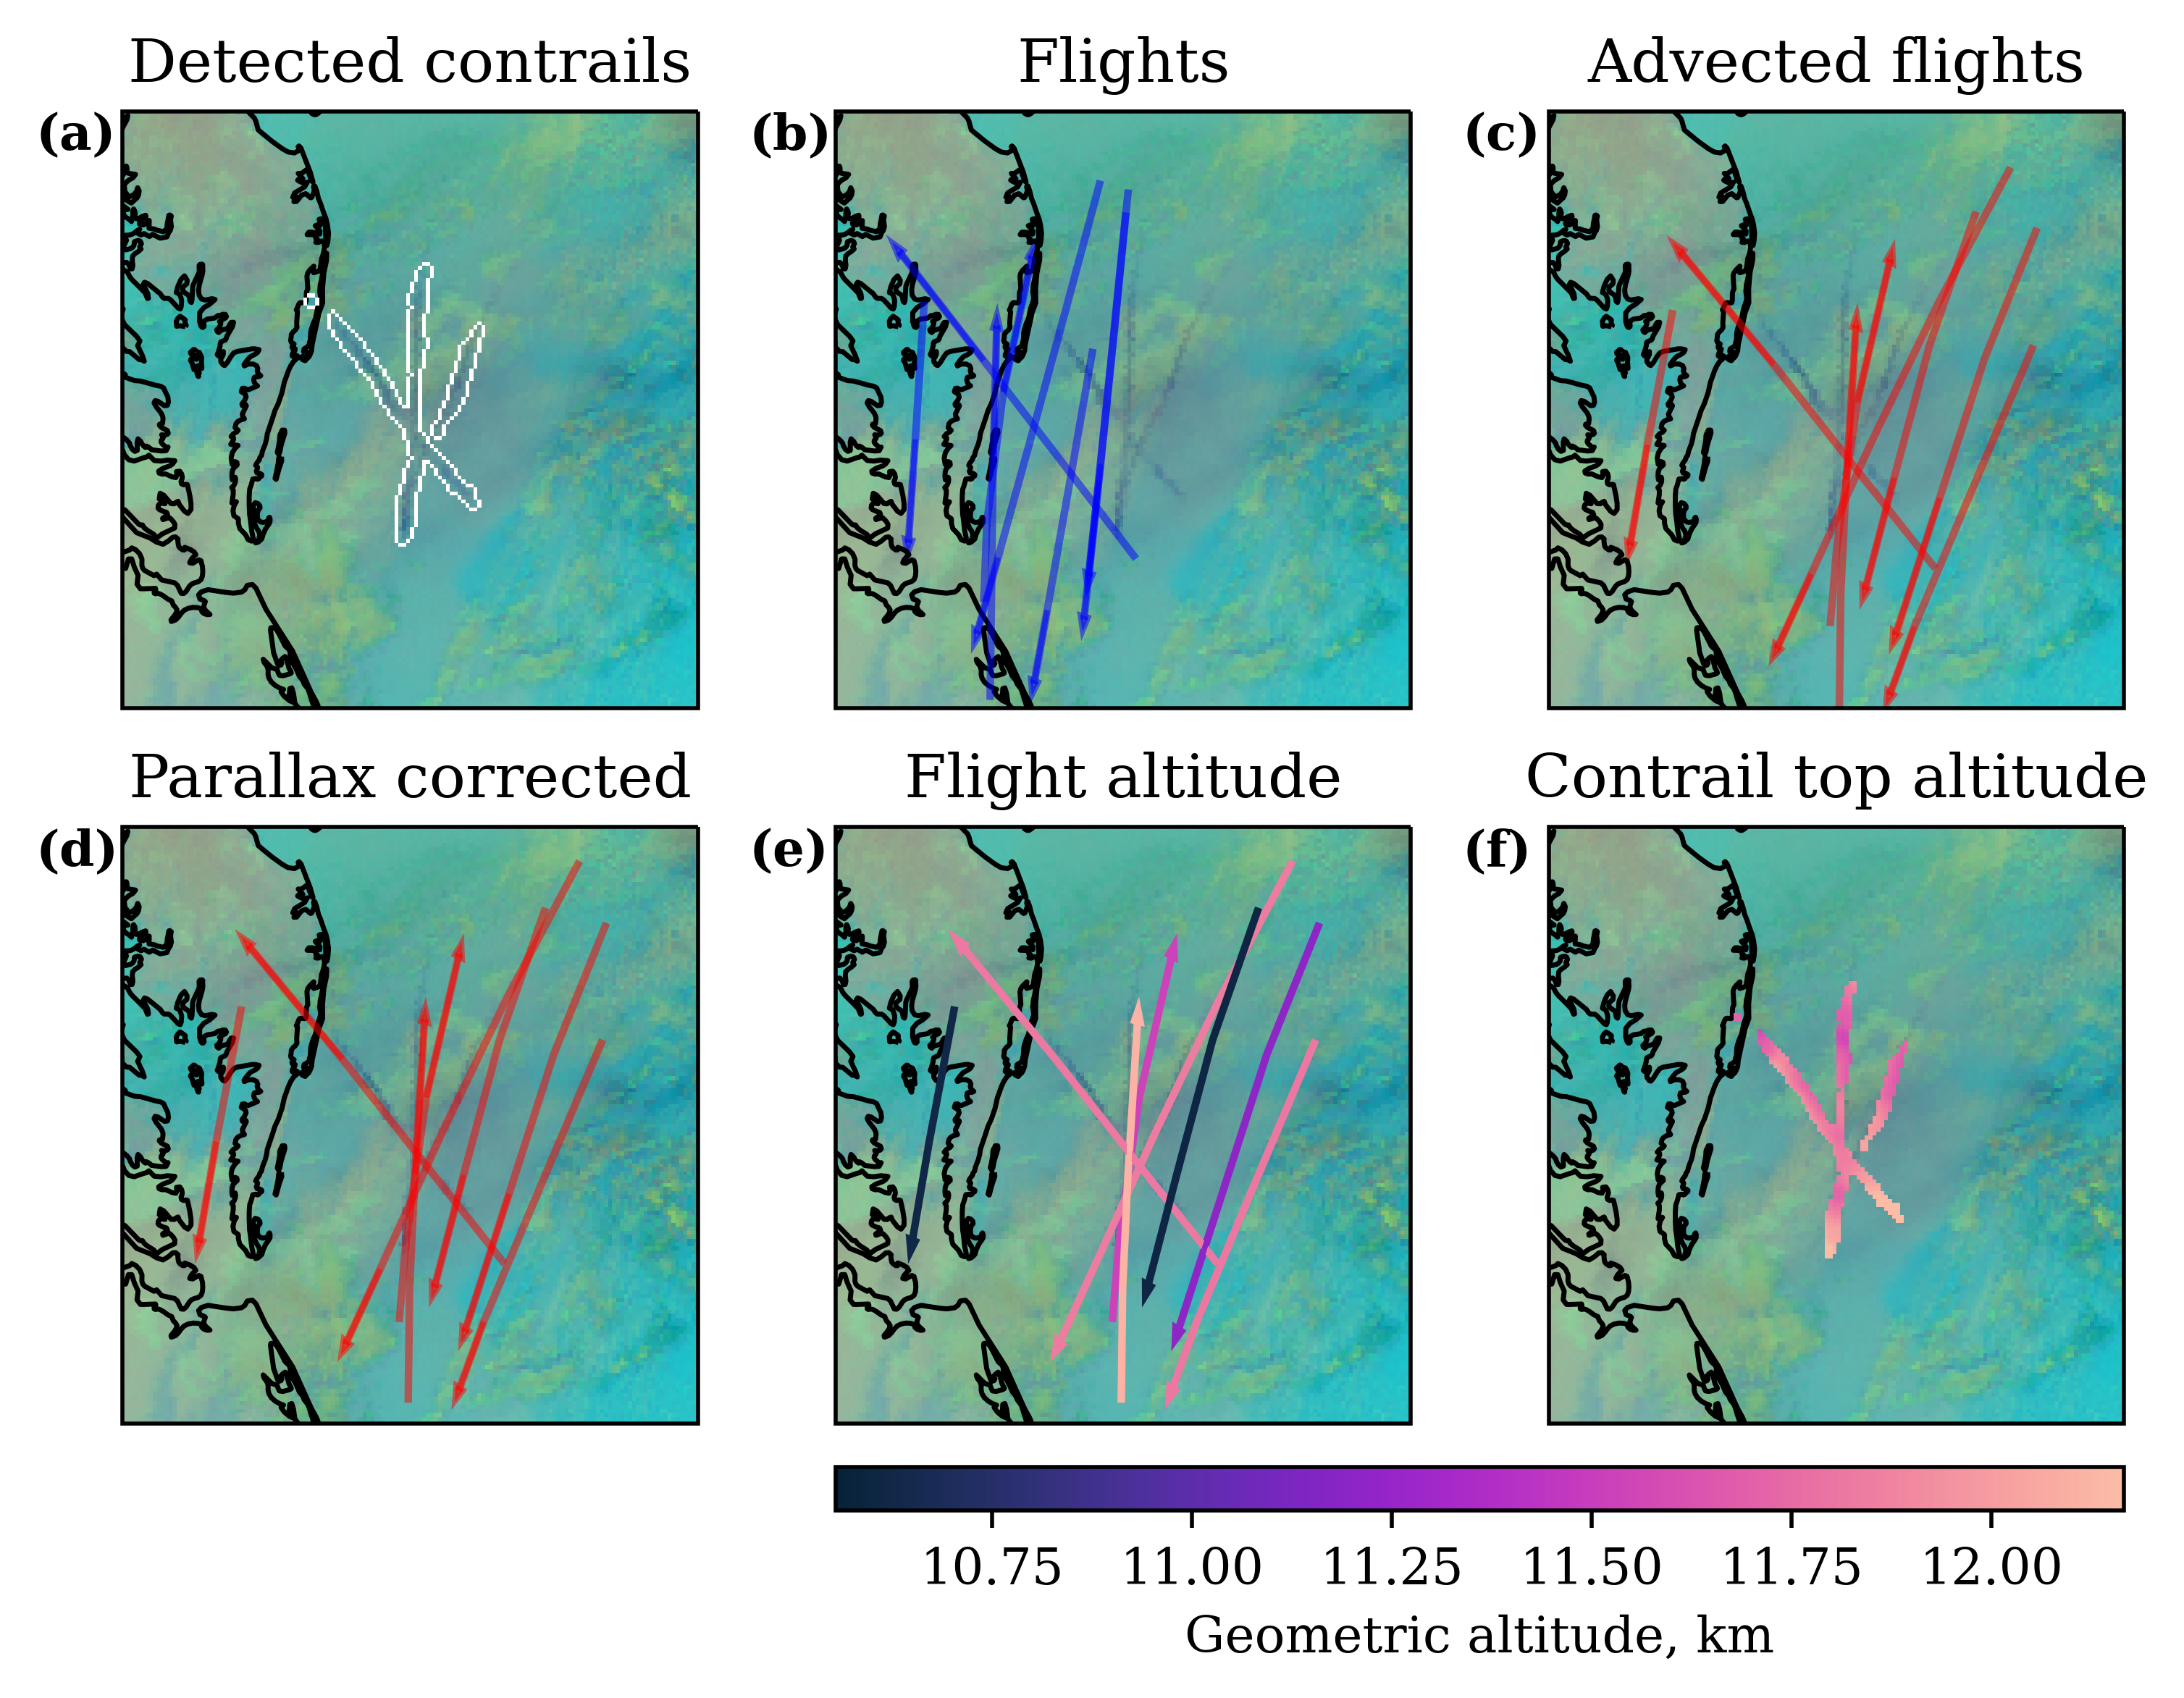

In [15]:
fig, axes = plt.subplots(dpi=500, figsize=(7.2, 7.2 * 2 /3), subplot_kw=dict(projection=ORTHO_PROJ), ncols=3, nrows=2)

for i in range(3):
    for j in range(2):
        axes[j,i].imshow(ash, origin='upper', extent=ORTHO_EXTENT)

        axes[j,i].set_extent(geo_extent, ccrs.PlateCarree())
        axes[j,i].coastlines()

        
        
vmin = oi.geometric_altitude.min()
vmax = oi.geometric_altitude.max()
    
    
    
bndries = binary_dilation(mask) - mask
axes[0,0].imshow(np.ma.masked_array(bndries, mask=bndries==0.0),
               extent=ORTHO_EXTENT, origin='upper', cmap='gray_r', zorder=5)


markers = {"AVA020" : "o", "VOC4085": "s", "ACA091" : "^"}

for f in oi.callsign.unique():
    
    flight = oi[oi.callsign.str.contains(f)]
    
    if len(flight) > 1:
    
        flight.plot(ax=axes[0,1], x="longitude", y="latitude", c="b", alpha=0.5, label=f, legend=False,
                        transform=ccrs.PlateCarree())

        axes[0,1].arrow(flight.iloc[-2].longitude, flight.iloc[-2].latitude,
                (flight.iloc[-1].longitude - flight.iloc[-2].longitude),
                (flight.iloc[-1].latitude - flight.iloc[-2].latitude),
                transform=ccrs.PlateCarree(), color="b", alpha=0.5, head_width=0.05, width=0)




        flight.plot(ax=axes[0,2], x="adv_lon", y="adv_lat", c="r", alpha=0.5, label=f, legend=False,
                        transform=ccrs.PlateCarree())


        axes[0,2].arrow(flight.iloc[-2].adv_lon, flight.iloc[-2].adv_lat,
                (flight.iloc[-1].adv_lon - flight.iloc[-2].adv_lon),
                (flight.iloc[-1].adv_lat - flight.iloc[-2].adv_lat),
                transform=ccrs.PlateCarree(), color="r", alpha=0.5, head_width=0.05, width=0)


        flight.plot(ax=axes[1,0], x="adv_lon_par", y="adv_lat_par", c="r", alpha=0.5, label=f, legend=False,
                        transform=ccrs.PlateCarree())

        axes[1,0].arrow(flight.iloc[-2].adv_lon_par, flight.iloc[-2].adv_lat_par,
                (flight.iloc[-1].adv_lon_par - flight.iloc[-2].adv_lon_par),
                (flight.iloc[-1].adv_lat_par - flight.iloc[-2].adv_lat_par),
                transform=ccrs.PlateCarree(), color="r", alpha=0.5, head_width=0.05, width=0)



        color = colormaps.bubblegum((flight.geometric_altitude.median() - vmin)/(vmax-vmin))

        flight.plot(ax=axes[1,1], x="adv_lon_par", y="adv_lat_par", c=color, alpha=1.0, legend=False,
                    transform=ccrs.PlateCarree())

        axes[1,1].arrow(flight.iloc[-2].adv_lon_par, flight.iloc[-2].adv_lat_par,
            (flight.iloc[-1].adv_lon_par - flight.iloc[-2].adv_lon_par),
            (flight.iloc[-1].adv_lat_par - flight.iloc[-2].adv_lat_par),
            transform=ccrs.PlateCarree(), color=color, alpha=1.0, head_width=0.05, width=0,zorder=5)


 
    
for i in range(3):
    for j in range(2):
        axes[j,i].set_yticks([])
        
        axes[j,i].text(-0.15, 1.0, "(" + chr(97 + i + j * 3) + ")", transform=axes[j,i].transAxes, 
            size=10, weight="bold", va="top")
    
axes[0,0].set(title="Detected contrails")
axes[0,1].set(title="Flights")
axes[0,2].set(title="Advected flights")
axes[1,0].set(title="Parallax corrected")
axes[1,1].set(title="Flight altitude")
axes[1,2].set(title="Contrail top altitude")

cf = axes[1,2].imshow(height_mask, extent=ORTHO_EXTENT, origin='upper',cmap=colormaps.bubblegum,
                     vmin=vmin,vmax=vmax, zorder=5)

pos2 = axes[1,2].get_position()
pos1 = axes[1,1].get_position()

cax = fig.add_axes([pos1.x0, pos1.y0 - 0.05, pos2.x1-pos1.x0, 0.025])
plt.colorbar(cf, cax=cax, orientation="horizontal", label="Geometric altitude, km")